In [6]:
import pandas as pd

df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'Text'])

df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [8]:
def create_balanced_dataset(df):
	num_spam = df[df['Label'] == 'spam'].shape[0]
	hum_subset = df[df['Label'] == 'ham'].sample(num_spam, random_state=123)
	balanced_df = pd.concat([hum_subset, df[df['Label'] == 'spam']])
	return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


In [9]:
balanced_df["Label"] = balanced_df["Label"].map({'ham': 0, 'spam': 1})

In [10]:
def random_split(df, train_ratio, validation_ratio):
	
	df = df.sample(frac=1, random_state=123).reset_index(drop=True)
	train_end = int(train_ratio * len(df))
	validation_end = int((train_ratio + validation_ratio) * len(df))
	
	train_df = df[:train_end]
	validation_df = df[train_end:validation_end]
	test_df = df[validation_end:]
	
	return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv('train.csv', index=None)
validation_df.to_csv('validation.csv', index=None)
test_df.to_csv('test.csv', index=None)


	

In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

class SpamDataset(Dataset):
	def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
		self.data = pd.read_csv(csv_file)
		
		self.encoded_texts = [
			tokenizer.encode(text) for text in self.data["Text"]
		]
		
		if max_length is None:
			self.max_length = max(len(text) for text in self.encoded_texts)
		else:
			self.max_length = max_length
			
		self.encoded_texts = [
			text[:self.max_length] + [pad_token_id] * (self.max_length - len(text))
			for text in self.encoded_texts
		]
		
	def __len__(self):
		return len(self.encoded_texts)

	def __getitem__(self, idx):
		encoded = self.encoded_texts[idx]
		label = self.data.iloc[idx]["Label"]
		return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

	def _longest_encoded_length(self):
		max_length = max(len(text) for text in self.encoded_texts)



None


In [13]:
train_dataset = SpamDataset("train.csv", tokenizer, max_length=128)
# validation_dataset = SpamDataset("validation.csv", tokenizer, max_length=128)

print(train_dataset.max_length)

128


In [14]:
val_dataset = SpamDataset("validation.csv", tokenizer, max_length=train_dataset.max_length)
test_dataset = SpamDataset("test.csv", tokenizer, max_length=train_dataset.max_length)

In [15]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
	train_dataset, 
	batch_size=batch_size, 
	shuffle=True, 
	num_workers=num_workers,
	drop_last=True
)
val_loader = DataLoader(
	val_dataset, 
	batch_size=batch_size, 
	shuffle=False, 
	num_workers=num_workers,
	drop_last=True
)
test_loader = DataLoader(
	test_dataset, 
	batch_size=batch_size, 
	shuffle=False, 
	num_workers=num_workers,
	drop_last=True
)



In [16]:
for input_batch, target_batch in train_loader:
	pass
print("Input batch dimensions:", input_batch.shape)
print("Labels batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 128])
Labels batch dimensions: torch.Size([8])


In [17]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")





130 training batches
18 validation batches
37 test batches


In [18]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
	"vocab_size": 50257,
	"context_length": 1024,
	"drop_rate": 0.0,
	"qkv_bias": True,
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)






In [25]:
from gpt_download import download_and_load_gpt2
import import_ipynb
from ch5 import GPTModel, load_weights_into_gpt

In [26]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()








File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [27]:
from ch4 import generate_text_simple
from ch5 import text_to_token_ids, token_ids_to_text

text1 = "Every effort moves you"
token_ids = generate_text_simple(
	model, 
	idx=text_to_token_ids(text1, tokenizer),
	max_new_tokens=15,
	context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [29]:
text2 = (
	"Is the following text 'spam'? Answer with 'yes' or 'no':\n"
	"You are the winner of the lottery\n"
	" selected to recieve a $1000 gift card"
)
token_ids = generate_text_simple(
	model, 
	idx=text_to_token_ids(text2, tokenizer),
	max_new_tokens=15,
	context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no':
You are the winner of the lottery
 selected to recieve a $1000 gift card.

You are the winner of the lottery selected to receive a $


In [30]:
## We are going to replace the output layer with a binary classification head

## Also to prepare for fine-tuning, we are going to freeze all the weights of the pre-trained model

for param in model.parameters():
	param.requires_grad = False

In [31]:
## Classification layer

torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
	in_features=BASE_CONFIG["emb_dim"], 
	out_features=num_classes
)







In [32]:
## Make the last block and final norm layer trainable

for param in model.trf_blocks[-1].parameters():
	param.requires_grad = True
for params in model.final_norm.parameters():
	params.requires_grad = True

In [33]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs shape:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs shape: torch.Size([1, 4])


In [34]:
with torch.no_grad():
	outputs = model(inputs)
print("Outputs shape:", outputs.shape)
print("Outputs:", outputs)

Outputs shape: torch.Size([1, 4, 2])
Outputs: tensor([[[-1.5854e+00,  9.9035e-01],
         [-3.7235e+00,  7.4548e+00],
         [-2.2661e+00,  6.6049e+00],
         [-3.5983e+00,  3.9902e+00]]])


In [36]:
## The number of rows corresponds to the number of input tokens. We're only interested in the last row

print("Last output token:", outputs[:, -1, :])



Last output token: tensor([[-3.5983e+00,  3.9902e+00]])


In [38]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Label:", label.item())


Label: 1


In [39]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [40]:
def cal_accuracy_loader(data_loader, model, device, num_batches=None):
	model.eval()
	total_correct = 0
	total_samples = 0

	if num_batches is not None:
		num_batches = min(num_batches, len(data_loader))
	else:
		num_batches = len(data_loader)
	
	for i, (input_batch, target_batch) in enumerate(data_loader):
		if i < num_batches:
			input_batch = input_batch.to(device)
			target_batch = target_batch.to(device)

			with torch.no_grad():
				logits = model(input_batch)[:, -1, :]
				predicted_class = torch.argmax(logits, dim=1)
				total_correct += (predicted_class == target_batch).sum().item()
				total_samples += predicted_class.shape[0]

		else:
			break
	
	accuracy = total_correct / total_samples
	return accuracy

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = cal_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = cal_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = cal_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")



Train accuracy: 0.4625
Validation accuracy: 0.4500
Test accuracy: 0.4750


In [42]:
def calc_loss_batch(input_batch, target_batch, model, device):
	input_batch = input_batch.to(device)
	target_batch = target_batch.to(device)

	logits = model(input_batch)[:, -1, :]
	loss = torch.nn.functional.cross_entropy(logits, target_batch)
	return loss

In [43]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
	total_loss = 0
	if len(data_loader) == 0:
		return float('nan')
	elif num_batches is None:
		num_batches = len(data_loader)
	else:
		num_batches = min(num_batches, len(data_loader))
	
	for i, (input_batch, target_batch) in enumerate(data_loader):
		if i < num_batches:
			loss = calc_loss_batch(input_batch, target_batch, model, device)
			total_loss += loss.item()
		else:
			break
	
	avg_loss = total_loss / num_batches
	return avg_loss


		

In [44]:
with torch.no_grad():
	train_loss = calc_loss_loader(train_loader, model, device, num_batches=10)
	val_loss = calc_loss_loader(val_loader, model, device, num_batches=10)
	test_loss = calc_loss_loader(test_loader, model, device, num_batches=10)

print(f"Train loss: {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")
print(f"Test loss: {test_loss:.4f}")






Train loss: 2.9057
Validation loss: 2.8386
Test loss: 2.6986


In [ ]:
def train_classifier_simple(
	model, train_loader, val_loader, optimizer, device,
	num_epochs, eval_freq, eval_iter
):
	train_losses, val_losses, train_accs, val_accs = [], [], [], []
	examples_seen, global_step = 0, -1

	for epoch in range(num_epochs):
		model.train()
		
		for input_batch, target_batch in train_loader:
			optimizer.zero_grad()
			loss = calc_loss_batch(input_batch, target_batch, model, device)
			loss.backward()
			optimizer.step()

			global_step += 1
			examples_seen += input_batch.shape[0]
			
			if global_step % eval_freq == 0:
				train_loss, val_loss = evaluate_model(
					model, train_loader, val_loader, device, eval_iter
				)
				train_losses.append(train_loss)
				val_losses.append(val_loss)

				print(f"Epoch {epoch+1}/{num_epochs}, Step {global_step}, "
					  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
	
		train_accuracy = cal_accuracy_loader(
			train_loader, model, device, num_batches=eval_iter
		)
		val_accuracy = cal_accuracy_loader(
			val_loader, model, device, num_batches=eval_iter
		)

		print(f"Train Accuracy: {train_accuracy*100:.2f}%, Val Accuracy: {val_accuracy*100:.2f}%")
		
		train_accs.append(train_accuracy)
		val_accs.append(val_accuracy)

	return train_losses, val_losses, train_accs, val_accs, examples_seen
	

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
	model.eval()
	with torch.no_grad():
		train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
		val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
		
	model.train()
	return train_loss, val_loss
	
	
	
	
	

In [46]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
	model, train_loader, val_loader, optimizer, device, num_epochs, 50, 5
)


end_time = time.time()
print(f"Training time: {(end_time - start_time) / 60:.2f} minutes")







Epoch 1/5, Step 0, Train Loss: 2.1552, Val Loss: 2.3930
Epoch 1/5, Step 50, Train Loss: 0.6114, Val Loss: 0.6328
Epoch 1/5, Step 100, Train Loss: 0.5207, Val Loss: 0.5540
Train Accuracy: 70.00%, Val Accuracy: 72.50%
Validation Accuracy: 72.50%
Epoch 2/5, Step 150, Train Loss: 0.5584, Val Loss: 0.4844
Epoch 2/5, Step 200, Train Loss: 0.4193, Val Loss: 0.3934
Epoch 2/5, Step 250, Train Loss: 0.4077, Val Loss: 0.3506
Train Accuracy: 82.50%, Val Accuracy: 85.00%
Validation Accuracy: 85.00%
Epoch 3/5, Step 300, Train Loss: 0.3390, Val Loss: 0.3159
Epoch 3/5, Step 350, Train Loss: 0.3452, Val Loss: 0.3135
Train Accuracy: 82.50%, Val Accuracy: 85.00%
Validation Accuracy: 85.00%
Epoch 4/5, Step 400, Train Loss: 0.2682, Val Loss: 0.3103
Epoch 4/5, Step 450, Train Loss: 0.3571, Val Loss: 0.2982
Epoch 4/5, Step 500, Train Loss: 0.3403, Val Loss: 0.3265
Train Accuracy: 90.00%, Val Accuracy: 85.00%
Validation Accuracy: 85.00%
Epoch 5/5, Step 550, Train Loss: 0.2861, Val Loss: 0.2664
Epoch 5/5, Step

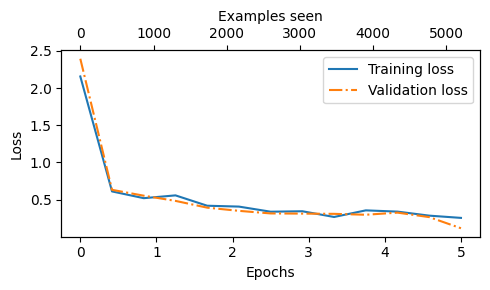

In [47]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [49]:
## Trying to fine-tune the entire model
for param in model.parameters():
	param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
	model, train_loader, val_loader, optimizer, device, num_epochs, 50, 5
)







Epoch 1/5, Step 0, Train Loss: 1.6117, Val Loss: 0.4669
Epoch 1/5, Step 50, Train Loss: 0.0267, Val Loss: 0.0539
Epoch 1/5, Step 100, Train Loss: 0.4016, Val Loss: 0.5039
Train Accuracy: 95.00%, Val Accuracy: 97.50%
Validation Accuracy: 97.50%
Epoch 2/5, Step 150, Train Loss: 0.0155, Val Loss: 0.1055
Epoch 2/5, Step 200, Train Loss: 0.1680, Val Loss: 0.0129
Epoch 2/5, Step 250, Train Loss: 0.0661, Val Loss: 0.2127
Train Accuracy: 100.00%, Val Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch 3/5, Step 300, Train Loss: 0.1624, Val Loss: 0.0652
Epoch 3/5, Step 350, Train Loss: 0.0088, Val Loss: 0.0920
Train Accuracy: 100.00%, Val Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch 4/5, Step 400, Train Loss: 0.1166, Val Loss: 0.0073
Epoch 4/5, Step 450, Train Loss: 0.0016, Val Loss: 0.0019
Epoch 4/5, Step 500, Train Loss: 0.0015, Val Loss: 0.0210
Train Accuracy: 100.00%, Val Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch 5/5, Step 550, Train Loss: 0.0032, Val Loss: 0.0064
Epoch 

In [50]:
train_accuracy = cal_accuracy_loader(
	train_loader, model, device
)
val_accuracy = cal_accuracy_loader(
	val_loader, model, device
)
test_accuracy = cal_accuracy_loader(
	test_loader, model, device
)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")


Train accuracy: 99.71%
Validation accuracy: 99.31%
Test accuracy: 97.97%


In [51]:
def classify_review(
	text, model, tokenizer, device, max_length=None,
	pad_token_id=50256
):
	model.eval()
	
	input_ids = tokenizer.encode(text)
	supported_context_length = model.pos_emb.weight.shape[0]

	input_ids = input_ids[:min(max_length, supported_context_length)]
	input_ids += [pad_token_id] * (max_length - len(input_ids))
	
	input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

	with torch.no_grad():
		logits = model(input_tensor)[:, -1, :]
	predicted_class = torch.argmax(logits, dim=-1).item()

	return "spam" if predicted_class == 1 else "not spam"


In [52]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [53]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [54]:
torch.save(model.state_dict(), "review_classifier.pth")